<a href="https://colab.research.google.com/github/rahul94jh/MSC-Research/blob/main/save_clickbait_as_tfrec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root = "/content/drive/MyDrive/Colab Notebooks/Clickbait detection"


#Imports

In [ ]:
import os, sys, math
import numpy as np
import random
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

Tensorflow version 2.4.1


#Load Data

In [ ]:
dataset_path = os.path.join(root, "clickbait_dataset/clickbait_filtered_with_image_path.csv")

df = pd.read_csv(dataset_path)
df.shape

(15572, 4)

In [ ]:
df.sample(3)

,title,description,thumbnail_320_180,is_clickbait
4696,worst typos of history,in which john having discovered an inevitable ...,/content/drive/MyDrive/Colab Notebooks/Clickba...,0
12626,strip twister,well someone s getting naked thumbs up subscri...,/content/drive/MyDrive/Colab Notebooks/Clickba...,1
3050,helicopter mission impossible gta funny moments,let s go for likes subscribe for more videos c...,/content/drive/MyDrive/Colab Notebooks/Clickba...,1


In [ ]:
df['title_desc'] = df.title+' '+df.description

#Configuration

In [ ]:
CLASSES = [b'nonclickbaits', b'clickbaits'] 
SHARDS = 16
TARGET_SIZE = [180, 180]


In [ ]:
#@title "Utilities [RUN ME]"
def parse_function(image_path, text, label):
    image_string = tf.io.read_file(image_path)

    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    return image, text, label

def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(CLASSES[label.numpy()], fontsize=16)
    subplot += 1
    if i==8:
      break
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

#Create dataset

In [ ]:
Y = df.pop('is_clickbait')
X_IMAGE = df['thumbnail_320_180']
X_TEXT = df['title_desc']

In [ ]:
Y = np.array(Y)
X_IMAGE = np.array(X_IMAGE)
X_TEXT = np.array(X_TEXT)
Y.shape, X_IMAGE.shape, X_TEXT.shape

((15572,), (15572,), (15572,))

In [ ]:
X_IMAGE[1], X_TEXT[1],Y[1]

('/content/drive/MyDrive/Colab Notebooks/Clickbait detection/clickbait_dataset/images/_ASn9eJNL64_mqdefault.jpg',
 'face punch img some images i stumbled on this week i liked links wedded bliss barn tattoo jesus on water sesame street fighter stickers college humor pics best mug shots imgur top big things willard wiggan doorbells perfect timing sleep tape underwear dope boxers snow fridge sleep on phone water camo animal camo mall prank cap lincoln paris view',
 0)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X_IMAGE, X_TEXT, Y))
dataset1 = dataset.map(parse_function, num_parallel_calls=AUTO)

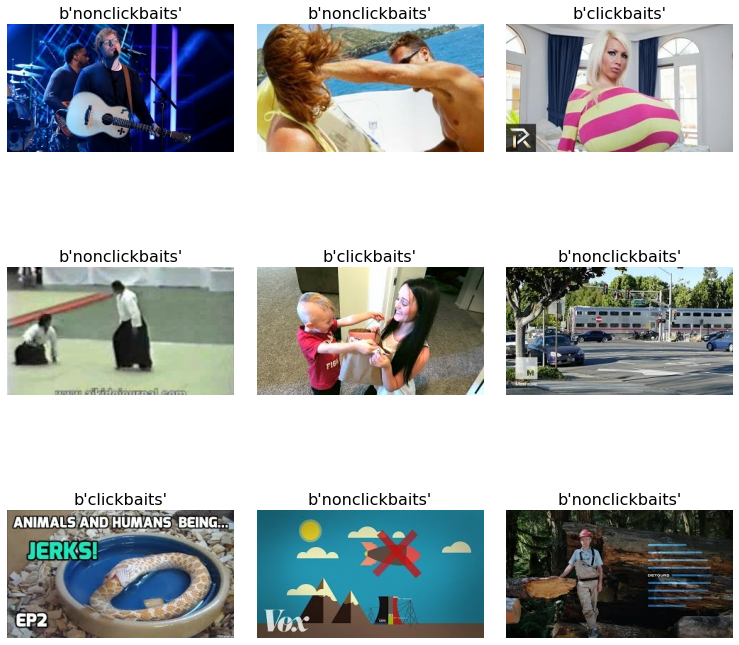

In [ ]:
display_9_images_from_dataset(dataset1)

#Resize and crop images to common size

In [ ]:
def resize_and_crop_image(image, text, label):
  # Resize and crop using "fill" algorithm:
  # always make sure the resulting image
  # is cut out from the source image so that
  # it fills the TARGET_SIZE entirely with no
  # black bars and a preserved aspect ratio.
  w = tf.shape(image)[0]
  h = tf.shape(image)[1]
  tw = TARGET_SIZE[1]
  th = TARGET_SIZE[0]
  resize_crit = (w * th) / (h * tw)
  image = tf.cond(resize_crit < 1,
                  lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                  lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                 )
  nw = tf.shape(image)[0]
  nh = tf.shape(image)[1]
  image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
  return image, text, label
  
dataset2 = dataset1.map(resize_and_crop_image, num_parallel_calls=AUTO) 

In [ ]:
for image, text, label in dataset2.take(10):
  print(image.numpy().shape, CLASSES[label.numpy()])

(180, 180, 3) b'nonclickbaits'
(180, 180, 3) b'nonclickbaits'
(180, 180, 3) b'clickbaits'
(180, 180, 3) b'nonclickbaits'
(180, 180, 3) b'clickbaits'
(180, 180, 3) b'nonclickbaits'
(180, 180, 3) b'clickbaits'
(180, 180, 3) b'nonclickbaits'
(180, 180, 3) b'nonclickbaits'
(180, 180, 3) b'nonclickbaits'


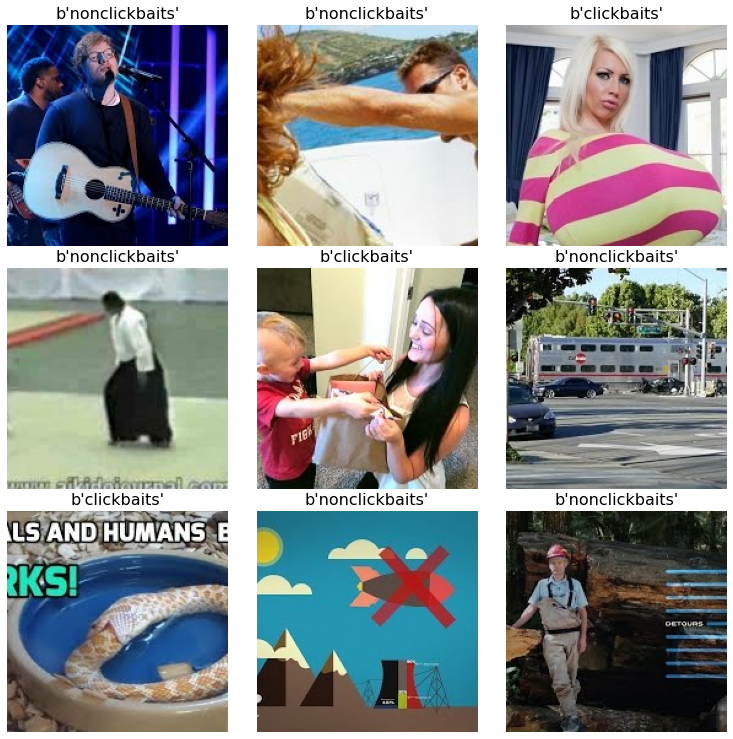

In [ ]:
display_9_images_from_dataset(dataset2)

#Recompress the images

In [ ]:
nb_images = len(dataset2)
shard_size = math.ceil(1.0 * nb_images / SHARDS)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, SHARDS, shard_size))

Pattern matches 15572 images which will be rewritten as 16 .tfrec files containing 974 images each.


In [ ]:
def recompress_image(image,text, label):
  height = tf.shape(image)[0]
  width = tf.shape(image)[1]
  image = tf.cast(image, tf.uint8)
  image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  return image, text, label, height, width

dataset3 = dataset2.map(recompress_image, num_parallel_calls=AUTO)
dataset3 = dataset3.batch(shard_size) # sharding: there will be one "batch" of images per file 

#Write dataset to TFRecord files

In [ ]:
tfrec_root = os.path.join(root, 'clickbait_dataset/tfrec_data')
PATH_OUTPUT = os.path.join(tfrec_root,'image_text')
PATH_OUTPUT

'/content/drive/MyDrive/Colab Notebooks/Clickbait detection/clickbait_dataset/tfrec_data/image_text'

In [ ]:
if not os.path.exists(tfrec_root):
  os.mkdir(tfrec_root)

In [ ]:
# Three types of data can be stored in TFRecords: bytestrings, integers and floats
# They are always stored as lists, a single data element will be a list of size 1

def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def _float_feature(list_of_floats): # float32
  return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))
  

def to_tfrecord(tfrec_filewriter, img_bytes, text, label, height, width):  
  class_num = label 

  feature = {
      "image": _bytestring_feature([img_bytes]), # one image in the list
      "class": _int_feature([class_num]),        # one class in the list
      "text":  _bytestring_feature([text]),       # text feature   
      "label":         _bytestring_feature([CLASSES[label]]),          # fixed length (1) list of strings, the text label
      "size":          _int_feature([height, width]),         # fixed length (2) list of ints
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))
  


In [ ]:
print("Writing TFRecords")
for shard, (image, text, label, height, width) in enumerate(dataset3):
  # batch size used as shard size here
  shard_size = image.numpy().shape[0]
  # good practice to have the number of records in the filename
  filename = PATH_OUTPUT + "{:02d}-{}.tfrec".format(shard, shard_size)
  
  with tf.io.TFRecordWriter(filename) as out_file:
    for i in range(shard_size):
      example = to_tfrecord(out_file,
                            image.numpy()[i], # re-compressed image: already a byte string
                            text.numpy()[i],
                            label.numpy()[i],
                            height.numpy()[i],
                            width.numpy()[i])
      out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))

Writing TFRecords
Wrote file /content/drive/MyDrive/Colab Notebooks/Clickbait detection/clickbait_dataset/tfrec_data/image_text00-974.tfrec containing 974 records
Wrote file /content/drive/MyDrive/Colab Notebooks/Clickbait detection/clickbait_dataset/tfrec_data/image_text01-974.tfrec containing 974 records
Wrote file /content/drive/MyDrive/Colab Notebooks/Clickbait detection/clickbait_dataset/tfrec_data/image_text02-974.tfrec containing 974 records
Wrote file /content/drive/MyDrive/Colab Notebooks/Clickbait detection/clickbait_dataset/tfrec_data/image_text03-974.tfrec containing 974 records
Wrote file /content/drive/MyDrive/Colab Notebooks/Clickbait detection/clickbait_dataset/tfrec_data/image_text04-974.tfrec containing 974 records
Wrote file /content/drive/MyDrive/Colab Notebooks/Clickbait detection/clickbait_dataset/tfrec_data/image_text05-974.tfrec containing 974 records
Wrote file /content/drive/MyDrive/Colab Notebooks/Clickbait detection/clickbait_dataset/tfrec_data/image_text06-

#Read from TFRecord Dataset

In [ ]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        "text": tf.io.FixedLenFeature([], tf.string),
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "size":          tf.io.FixedLenFeature([2], tf.int64)  # two integers
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    
    class_num = example['class']
    text = example['text']
    label  = example['label']
    height = example['size'][0]
    width  = example['size'][1]
    return image, text, class_num, label, height, width


In [ ]:
# read from TFRecords. For optimal performance, read from multiple
# TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

filenames = tf.io.gfile.glob(PATH_OUTPUT + "*.tfrec")
len(filenames)

16

In [ ]:
dataset4 = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
dataset4 = dataset4.with_options(option_no_order)
dataset4 = dataset4.map(read_tfrecord, num_parallel_calls=AUTO)
dataset4 = dataset4.shuffle(300)

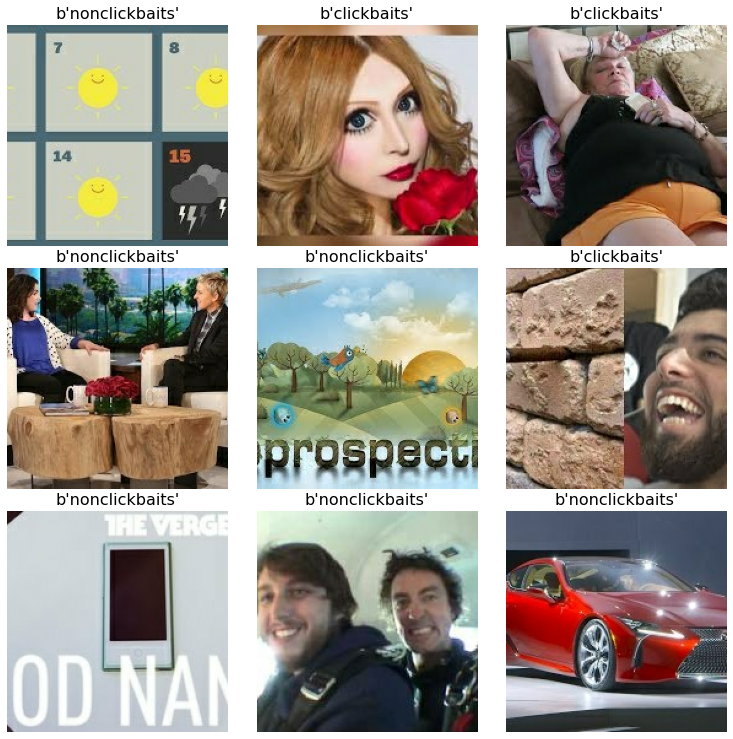

In [ ]:
display_dataset = dataset4.map(lambda image,text, class_num, label, height, width: (image, class_num))
display_9_images_from_dataset(display_dataset)

In [ ]:
dataset4 = dataset4.map(lambda image, text, class_num, label, height, width: ((image,text), class_num))
for (image, text), class_num in dataset4.take(300):
    print(f"Image shape {image.numpy().shape}, Text {text.numpy()}, Class={class_num.numpy()}, Label={CLASSES[class_num.numpy()]}")

Image shape (180, 180, 3), Text b'faze rain top plays week powered by scufgaming raindrops be sure to like subscribe my official apparel use code rainn for off on subscribe to my second channel watch me live at rain xbl picture pack twitter livestream facebook instagram st nd rd th th use code rainn the best xbox playstation controllers need an energy drink that s healthy increase your accuracy improve your game apparel presented by my mouse keyboard etc as always keep it real', Class=1, Label=b'clickbaits'
Image shape (180, 180, 3), Text b'will gaming laptops ever catch up to gaming desktops ces with nvidia to razer revealing gaming laptops at ces we discuss the strength and weaknesses of laptop gaming hardware watch more about ces here from bmw to faraday future the future of automotive tech ces we rode in a self driving uber car follow ign for more ign official app facebook twitter instagram website google ign ces', Class=0, Label=b'nonclickbaits'
Image shape (180, 180, 3), Text b'w